In [1]:
from functools import reduce

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

import src.mongos as mg
from src.common import *

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
prop = font_manager.FontProperties(fname=path)
mpl.rcParams['font.family'] = prop.get_name()

dir_item = '/home/jake/Documents/News_Item/'
dir_proj = dir_item + 'Cherry_Blossom/'
dir_tableau = dir_proj + 'tableau_data/'

# Load: ranking

In [2]:
ranking_raw = mg.read_mongo('gaon', 'all')
ranking_raw.head()

,album,album_img_src,change,date,distribution,gaon_score,production,ranking,singer,subject,week,year
0,우리 사랑하게 됐어요,,newnew,201001,카카오 M,None,내가 네트워크,1,"가인 (브라운 아이드 걸스), 조권 (2AM)",우리 사랑하게 됐어요.,01,2010
1,Shadow (Repackage),,newnew,201001,카카오 M,None,후크엔터테인먼트,2,이승기,처음처럼 그때처럼 (Feat. 강민경),01,2010
2,크리스마스에 눈이 올까요? OST,,newnew,201001,카카오 M,None,아이에이치큐,3,거미,그대라서,01,2010
3,Absolute First Album,,newnew,201001,Stone Music Entertainment,None,코어컨텐츠미디어,4,티아라 (T-ara),Bo Peep Bo Peep,01,2010
4,Atelier,,newnew,201001,카카오 M,None,카카오 M,5,지아 (Zia),술 한잔 해요,01,2010


# Prepare

In [3]:
def prepare_ranking(raw):
    ranking = raw.copy()
    ranking['change'].replace('newnew', 'new', inplace=True)
    ranking['date'].replace('201001', '2009.12.20~2009.12.26', inplace=True)
    ranking['ranking_num'] = ranking['ranking'].astype(int)
    ranking['ranking_value'] = 200 - ranking['ranking_num']
    ranking['gaon_score_num'] = ranking['gaon_score'].apply(lambda x: float(x.replace(',', '')) if x else np.nan)
    
    tmp = ranking.loc[ranking['ranking_num'] <= 100].groupby(['year', 'week']).agg({'gaon_score_num':'sum'}).reset_index()
    tmp.rename(columns={'gaon_score_num':'gaon_score_total'}, inplace='True')
    ranking = ranking.merge(tmp, on=['year', 'week'], how='left')
    ranking['gaon_score_rate'] = ranking['gaon_score_num'] / ranking['gaon_score_total'] * 100
    return ranking


def get_ranking(maximum):
    ranking_100 = ranking.loc[ranking['ranking_num'] <= maximum]
    return ranking_100


ranking = prepare_ranking(ranking_raw)
ranking_100 = get_ranking(100)


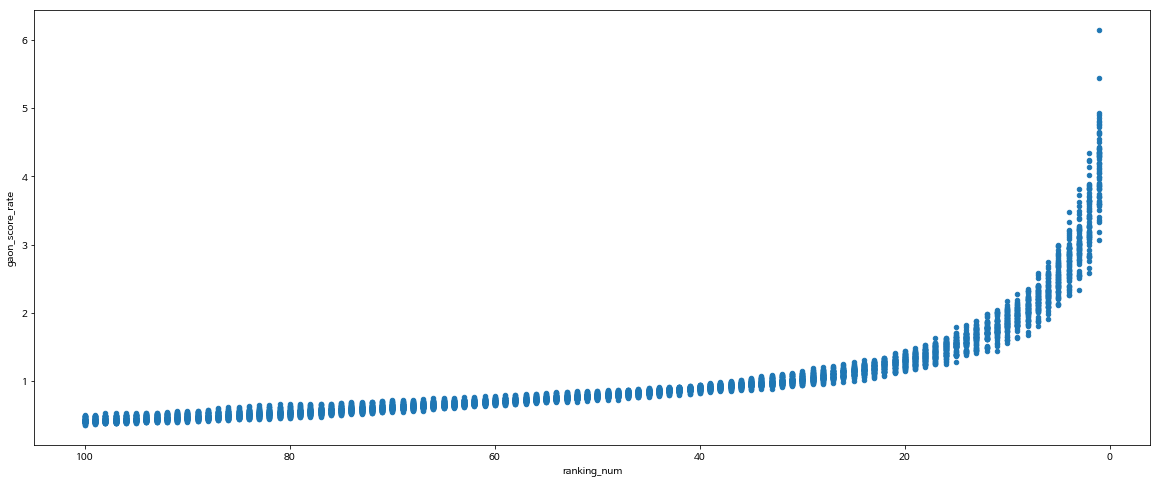

In [4]:
# draw pattern

# tmp = ranking_100.loc[(ranking['year']=='2019'), ['ranking_num', 'gaon_score_rate']]; tmp.head()
tmp = ranking_100.loc[(ranking['year'].isin(['2018', '2019'])), ['ranking_num', 'gaon_score_rate']]; tmp.head()
# tmp['gaon_score_rate'] = tmp['gaon_score_rate'].apply(np.log); tmp.head()
tmp.plot('ranking_num', 'gaon_score_rate', kind='scatter', figsize=(20, 8))
plt.gca().invert_xaxis()

In [5]:
# tmp.to_csv(dir_tableau + 'correlation.tsv', sep='\t', index=False)

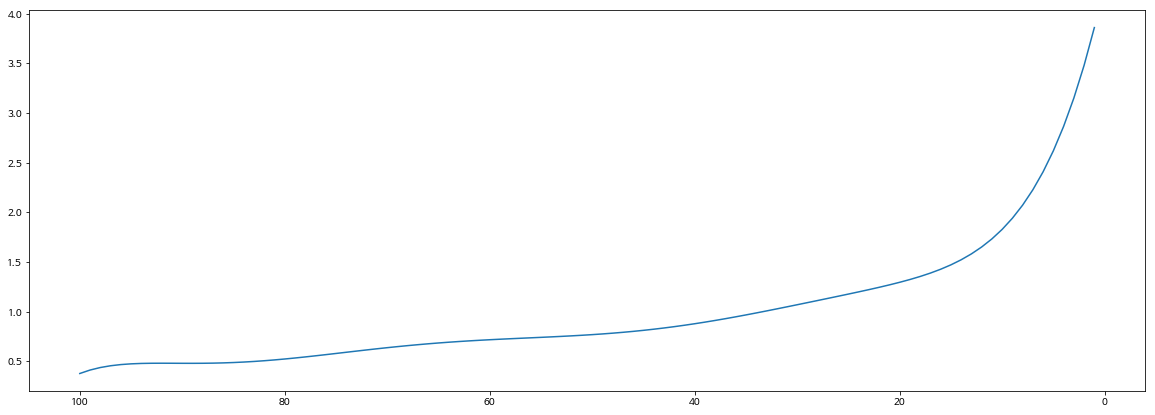

In [6]:
# draw_prediction

predict= np.array(range(1, 101)).reshape(-1, 1)

X = tmp['ranking_num'].values.reshape(-1, 1)
y = tmp['gaon_score_rate'].values.reshape(-1, 1)


def draw_prediction(degree):
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    rgr = linear_model.LinearRegression()
    rgr.fit(X_, y)
    
    predict_ = poly.fit_transform(predict)
    
    y_plot = rgr.predict(predict_)
    x_plot = predict
    plt.figure(figsize=(20,7))
    plt.plot(x_plot, y_plot, )
    plt.gca().invert_xaxis()


draw_prediction(7)

In [7]:
# get score_list
predict= np.array(range(1, 101)).reshape(-1, 1)

X = tmp['ranking_num'].values.reshape(-1, 1)
y = tmp['gaon_score_rate'].values.reshape(-1, 1)

def get_prediction():
    poly = PolynomialFeatures(degree=7)
    X_ = poly.fit_transform(X)
    rgr = linear_model.LinearRegression()
    rgr.fit(X_, y)
    
    predict_ = poly.fit_transform(predict)
    return rgr.predict(predict_)


tmp = get_prediction().reshape(1, -1)[0].tolist()
score_list = [np.nan] + tmp
score_list

[nan,
 3.859794078313984,
 3.479866406505378,
 3.1502781241119004,
 2.865255902625088,
 2.6195385242295743,
 2.4083443604950534,
 2.2273401670986877,
 2.0726111689901683,
 1.9406324104116748,
 1.8282413441849523,
 1.7326116346777427,
 1.6512281488617795,
 1.5818631098746057,
 1.5225533874974015,
 1.4715788999610933,
 1.4274421014929466,
 1.3888485300158546,
 1.35468838941261,
 1.3240191407673176,
 1.2960490769962227,
 1.2701218552801699,
 1.2457019617108962,
 1.222361082563463,
 1.1997653566069317,
 1.1776634828656327,
 1.1558756582431968,
 1.13428331942157,
 1.112819663447219,
 1.0914609214169104,
 1.0702183596750245,
 1.049130982934905,
 1.0282589137362095,
 1.0076774226507865,
 0.9874715836490537,
 0.967731529039142,
 0.9485482783912573,
 0.9300101158592042,
 0.9121994903113375,
 0.8951904126835188,
 0.8790463249656852,
 0.8638184152349879,
 0.8495443531468823,
 0.8362474202974113,
 0.823936009867964,
 0.8126034699652678,
 0.8022282650686634,
 0.7927744299970527,
 0.7841922908076242

In [8]:
# fill_gaon_score_rate

def fill_gaon_score_rate(row):
    ranking = row['ranking_num']

    if pd.isna(row['gaon_score_rate']):
        return score_list[ranking]
    else:
        return row['gaon_score_rate']


# ; ranking_100[['ranking', 'gaon_score_rate']].head()
ranking_100['gaon_score_rate'] = ranking_100.apply(fill_gaon_score_rate, axis=1)
ranking_100.head()

/home/jake/.virtualenvs/workspace/lib/python3.6/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,album,album_img_src,change,date,distribution,gaon_score,production,ranking,singer,subject,week,year,ranking_num,ranking_value,gaon_score_num,gaon_score_total,gaon_score_rate
0,우리 사랑하게 됐어요,,new,2009.12.20~2009.12.26,카카오 M,None,내가 네트워크,1,"가인 (브라운 아이드 걸스), 조권 (2AM)",우리 사랑하게 됐어요.,01,2010,1,199,NaN,0.0,3.859794
1,Shadow (Repackage),,new,2009.12.20~2009.12.26,카카오 M,None,후크엔터테인먼트,2,이승기,처음처럼 그때처럼 (Feat. 강민경),01,2010,2,198,NaN,0.0,3.479866
2,크리스마스에 눈이 올까요? OST,,new,2009.12.20~2009.12.26,카카오 M,None,아이에이치큐,3,거미,그대라서,01,2010,3,197,NaN,0.0,3.150278
3,Absolute First Album,,new,2009.12.20~2009.12.26,Stone Music Entertainment,None,코어컨텐츠미디어,4,티아라 (T-ara),Bo Peep Bo Peep,01,2010,4,196,NaN,0.0,2.865256
4,Atelier,,new,2009.12.20~2009.12.26,카카오 M,None,카카오 M,5,지아 (Zia),술 한잔 해요,01,2010,5,195,NaN,0.0,2.619539


In [9]:
# ranking_100.shape
ranking_100.tail()

,album,album_img_src,change,date,distribution,gaon_score,production,ranking,singer,subject,week,year,ranking_num,ranking_value,gaon_score_num,gaon_score_total,gaon_score_rate
49595,첫눈에,,down18,2019.03.24~2019.03.30,지니뮤직,"6,863,977","Stone Music Entertainment, Studio blu",96,헤이즈 (Heize),첫눈에,13,2019,96,104,6863977.0,1.590227e+09,0.431635
49596,강민경 1집,,down29,2019.03.24~2019.03.30,지니뮤직,"6,827,682",Stone Music Entertainment,97,강민경,사랑해서 그래,13,2019,97,103,6827682.0,1.590227e+09,0.429353
49597,DON`T MESS UP MY TEMPO - The 5th Album,,down7,2019.03.24~2019.03.30,IRIVER,"6,779,291",SM Entertainment,98,EXO,Tempo,13,2019,98,102,6779291.0,1.590227e+09,0.426310
49598,사랑에 연습이 있었다면,,up89,2019.03.24~2019.03.30,카카오 M,"6,558,202","엔에스씨컴퍼니, 디원미디어",99,임재현,사랑에 연습이 있었다면 (Prod. 2soo),13,2019,99,101,6558202.0,1.590227e+09,0.412407
49599,가을 안부,,down14,2019.03.24~2019.03.30,지니뮤직,"6,505,682",먼데이키즈 컴퍼니,100,먼데이키즈 (Monday Kiz),가을 안부,13,2019,100,100,6505682.0,1.590227e+09,0.409104


# Functions

In [10]:
def draw_line(ranking, k=10):
    x = ranking['year'] + ranking['week']
    y = ranking['ranking'].astype(int)
    subject = ranking.iloc[0]['subject']
    singer = ranking.iloc[0]['singer']
    
    plt.figure(figsize=(2*k, k))
    plt.plot(x, y, linewidth=3, linestyle="--", color="blue",)
#     plt.plot(x, y, linewidth=3, linestyle="--", color="blue", label=r"Legend label $\sin(x)$")
    plt.xlabel(r"Time")
    plt.ylabel(r"Ranking")
    plt.title(f'{subject}, {singer}')
    # plt.xlim(0, 2*np.pi)
    # plt.ylim(106, 0)
    plt.gca().invert_yaxis()
    plt.legend(loc="best")
    plt.show()

In [11]:
def concat_week(series):
    return reduce(lambda x, y: x + y, series)

# Explore: ranking

In [12]:
# 봄 키워드?
idx_cherry = ranking['subject'].str.contains('벚꽃')
ranking.loc[idx_cherry, 'subject'].value_counts()

벚꽃 엔딩         102
봄 사랑 벚꽃 말고    63 
벚꽃이 지면        9  
벚꽃연가          5  
벚꽃, 밤         1  
Name: subject, dtype: int64

In [13]:
# index

idx_ending = ranking_100['subject'] == '벚꽃 엔딩'
idx_iu = ranking_100['subject'] == '봄 사랑 벚꽃 말고'
idx_night = (ranking_100['subject'] == '밤편지') & (ranking_100['singer'] == '아이유 (IU)')
idx_ailee = (ranking_100['subject'] == '첫눈처럼 너에게 가겠다') & (ranking_100['singer'] == '에일리 (Ailee)')

# ranking.loc[idx_cherry, 'subject'].value_counts()

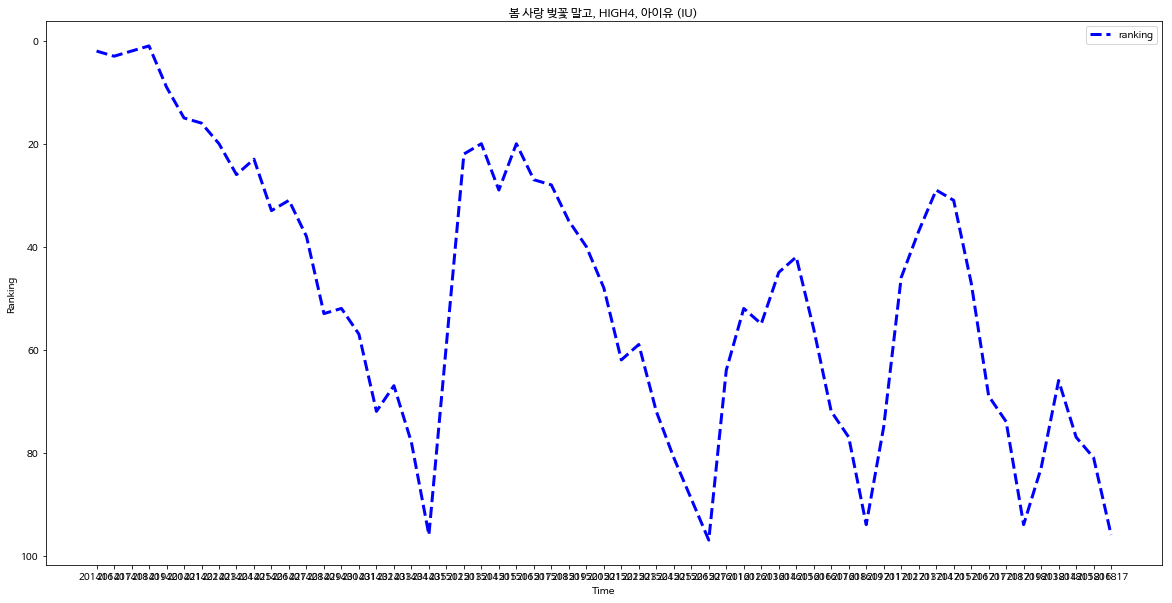

In [14]:
# 봄 사랑 벚꽃 말고
draw_line(ranking_100.loc[idx_iu])

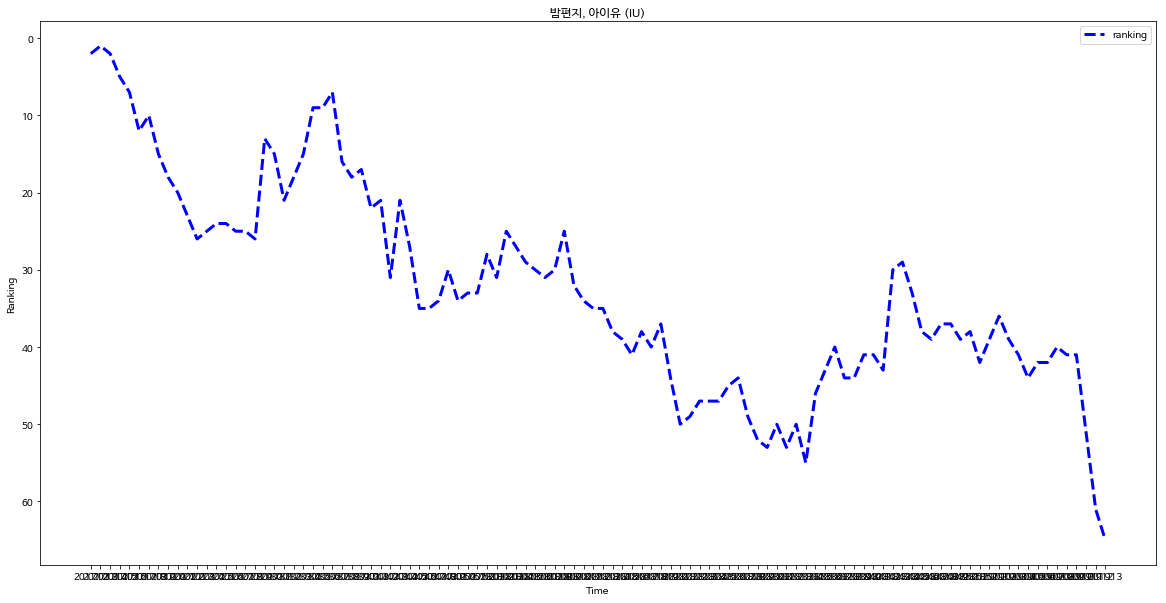

In [15]:
# 밤편지
draw_line(ranking_100.loc[idx_night])

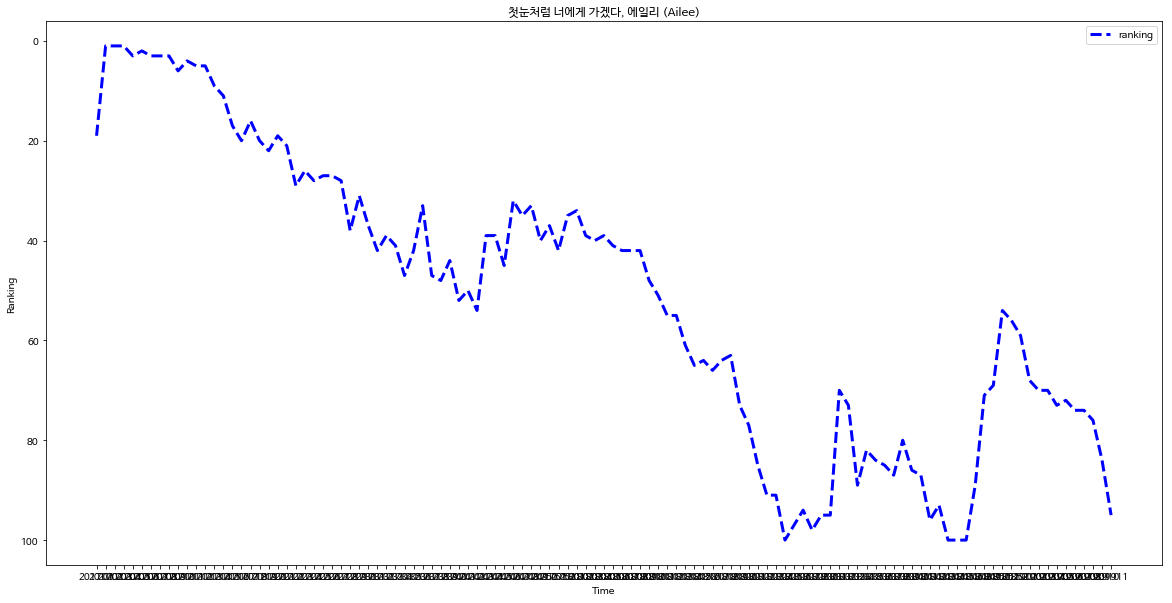

In [16]:
# 에일리
draw_line(ranking_100.loc[idx_ailee])

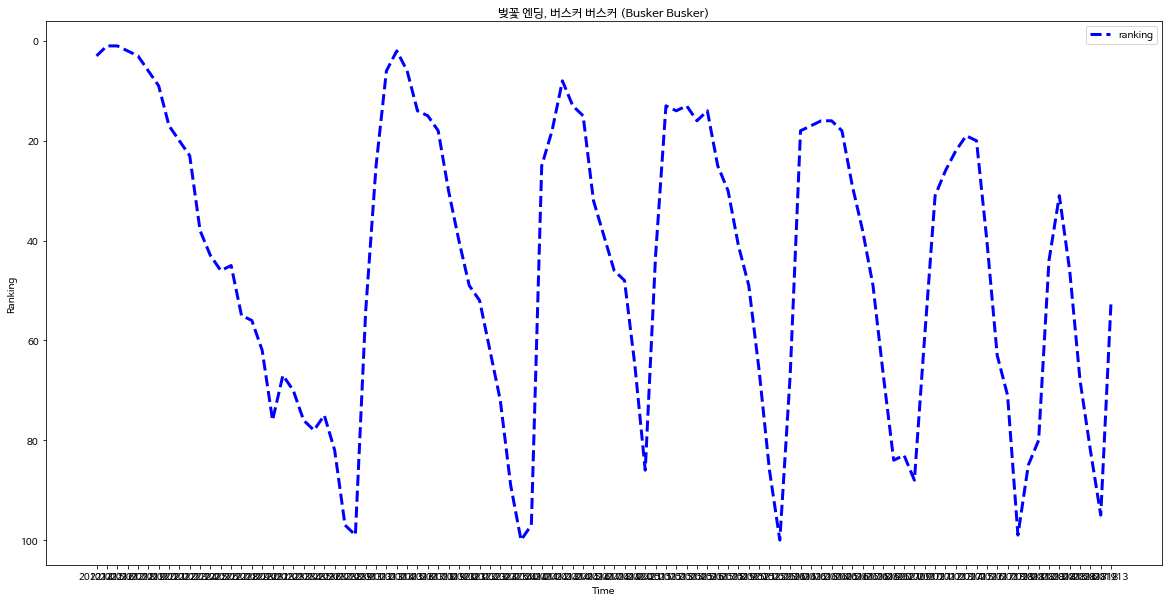

In [17]:
# 벚꽃 엔딩
draw_line(ranking_100.loc[idx_ending])

In [18]:
cols_trend = ['singer', 'subject', 'year', 'week', 'date', 'ranking_num',]
idx_trend = idx_ailee | idx_ending | idx_night
ranking_100.loc[idx_trend, cols_trend]
# ranking_100.loc[idx_trend, cols_trend].to_csv(dir_tableau + 'cherry_trend.tsv', sep='\t', index=False)

,singer,subject,year,week,date,ranking_num
11802,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,14,2012.03.25~2012.03.31,3
11900,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,15,2012.04.01~2012.04.07,1
12000,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,16,2012.04.08~2012.04.14,1
12101,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,17,2012.04.15~2012.04.21,2
12202,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,18,2012.04.22~2012.04.28,3
12305,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,19,2012.04.29~2012.05.05,6
12408,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,20,2012.05.06~2012.05.12,9
12516,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,21,2012.05.13~2012.05.19,17
12619,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,22,2012.05.20~2012.05.26,20
12722,버스커 버스커 (Busker Busker),벚꽃 엔딩,2012,23,2012.05.27~2012.06.02,23


In [19]:
ranking_100.loc[idx_ending, ['date','week','year','ranking',]]

,date,week,year,ranking
11802,2012.03.25~2012.03.31,14,2012,3
11900,2012.04.01~2012.04.07,15,2012,1
12000,2012.04.08~2012.04.14,16,2012,1
12101,2012.04.15~2012.04.21,17,2012,2
12202,2012.04.22~2012.04.28,18,2012,3
12305,2012.04.29~2012.05.05,19,2012,6
12408,2012.05.06~2012.05.12,20,2012,9
12516,2012.05.13~2012.05.19,21,2012,17
12619,2012.05.20~2012.05.26,22,2012,20
12722,2012.05.27~2012.06.02,23,2012,23


# Transform

## yearly

In [20]:
# yearly: 여러 해에 거쳐 나타난 노래
yearly = ranking.pivot_table(index=['singer', 'subject'], columns='year', values='week', aggfunc='count'); yearly.head()

yearly['count'] = yearly.count(axis=1)
yearly.reset_index(inplace=True); yearly.head()
# mg.to_mongo(yearly, 'gaon', 'yearly_week_count')

year,singer,subject,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,count
0,(여자)아이들,LATATA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,1.0,2
1,(여자)아이들,Senorita,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,1
2,(여자)아이들,한(一),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,11.0,2
3,"(여자)아이들, Madison Beer, Jaira Burns",POP/STARS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,2
4,100% V,퇴근길,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1


In [21]:
yearly['count'] = yearly.count(axis=1); yearly.head()
yearly.reset_index(inplace=True)
# mg.to_mongo(yearly, 'gaon', 'yearly_week_count')

# Load: yearly

In [22]:
yearly = mg.read_mongo('gaon', 'yearly_week_count'); yearly.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN
3,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0


In [23]:
yearly['count'] = yearly.count(axis=1); yearly.head()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,count
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1
1,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN,1
3,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,1


# Explore: yearly

In [24]:
# count > 2
yearly['count'].value_counts()

1     7729
2     1024
3     157 
4     43  
5     18  
6     7   
7     2   
9     2   
8     2   
10    1   
Name: count, dtype: int64

# 벚꽃엔딩 출현빈도

In [25]:
# print(ranking.loc[ranking['subject']=='벚꽃 엔딩'].shape)
ranking.loc[(ranking['subject']=='벚꽃 엔딩')&(ranking['singer']=='버스커 버스커 (Busker Busker)')].head()

,album,album_img_src,change,date,distribution,gaon_score,production,ranking,singer,subject,week,year,ranking_num,ranking_value,gaon_score_num,gaon_score_total,gaon_score_rate
11802,1집 버스커 버스커,,new,2012.03.25~2012.03.31,Stone Music Entertainment,None,Stone Music Entertainment,3,버스커 버스커 (Busker Busker),벚꽃 엔딩,14,2012,3,197,NaN,0.0,NaN
11900,1집 버스커 버스커,,up2,2012.04.01~2012.04.07,Stone Music Entertainment,None,Stone Music Entertainment,1,버스커 버스커 (Busker Busker),벚꽃 엔딩,15,2012,1,199,NaN,0.0,NaN
12000,1집 버스커 버스커,,-,2012.04.08~2012.04.14,Stone Music Entertainment,None,Stone Music Entertainment,1,버스커 버스커 (Busker Busker),벚꽃 엔딩,16,2012,1,199,NaN,0.0,NaN
12101,1집 버스커 버스커,,down1,2012.04.15~2012.04.21,Stone Music Entertainment,None,Stone Music Entertainment,2,버스커 버스커 (Busker Busker),벚꽃 엔딩,17,2012,2,198,NaN,0.0,NaN
12202,1집 버스커 버스커,,down1,2012.04.22~2012.04.28,Stone Music Entertainment,None,Stone Music Entertainment,3,버스커 버스커 (Busker Busker),벚꽃 엔딩,18,2012,3,197,NaN,0.0,NaN


# 차트 종합순위

## using ranking_value

In [26]:
# using ranking directly
tmp = ranking_100.groupby(['singer', 'subject']).agg({'week': 'count', 'ranking_value': 'mean', 'date':'first'})
tmp['value'] = tmp['week'] * tmp['ranking_value']
tmp.sort_values('value', ascending=False).head(30)

,,week,ranking_value,date,value
singer,subject,,,,
아이유 (IU),밤편지,106,167.452830,2017.03.19~2017.03.25,17750.0
Ed Sheeran,Shape of You,111,156.099099,2017.01.29~2017.02.04,17327.0
방탄소년단,봄날,111,153.234234,2017.02.12~2017.02.18,17009.0
에일리 (Ailee),첫눈처럼 너에게 가겠다,113,148.929204,2017.01.01~2017.01.07,16829.0
엠씨더맥스 (M.C The Max),어디에도,112,139.705357,2016.01.24~2016.01.30,15647.0
버스커 버스커 (Busker Busker),벚꽃 엔딩,99,155.464646,2012.03.25~2012.03.31,15391.0
Sam Smith,I`m Not The Only One,120,127.233333,2014.12.21~2014.12.27,15268.0
박효신,야생화,99,141.848485,2014.03.23~2014.03.29,14043.0
멜로망스(Melomance),선물,80,164.037500,2017.07.09~2017.07.15,13123.0


## using gaon_score_rate

In [27]:
tmp = ranking_100.groupby(['singer', 'subject']).agg({'gaon_score_rate': 'sum', 'date':'first'}).sort_values('gaon_score_rate', ascending=False);
tmp.reset_index(inplace=True)
tmp.index = tmp.index + 1
tmp.head(100)
# tmp.head(100).shape

# ranking[['singer', 'subject', 'year']].head()
# tmp.head(100).merge(ranking[['singer', 'subject', 'year']], on=['singer', 'subject'], how='inner',).head()
# tmp.merge(ranking[['singer', 'subject', 'year']], on=['singer', 'subject'], how='left',).groupby('year').agg('count')

# tmp.shape
# tmp['value'] = tmp['week'] * tmp['ranking_value']
# tmp.sort_values('value', ascending=False).head(30)

,singer,subject,gaon_score_rate,date
1,아이유 (IU),밤편지,121.121115,2017.03.19~2017.03.25
2,에일리 (Ailee),첫눈처럼 너에게 가겠다,118.452595,2017.01.01~2017.01.07
3,버스커 버스커 (Busker Busker),벚꽃 엔딩,111.052175,2012.03.25~2012.03.31
4,멜로망스(Melomance),선물,107.415742,2017.07.09~2017.07.15
5,Ed Sheeran,Shape of You,106.092605,2017.01.29~2017.02.04
6,방탄소년단,봄날,100.028867,2017.02.12~2017.02.18
7,iKON,사랑을 했다 (LOVE SCENARIO),92.840074,2018.01.21~2018.01.27
8,엠씨더맥스 (M.C The Max),어디에도,92.745519,2016.01.24~2016.01.30
9,폴킴,"모든 날, 모든 순간 (Every day, Every Moment)",92.499947,2018.03.18~2018.03.24
10,윤종신,좋니,91.593598,2017.06.25~2017.07.01


In [28]:
# tmp.head(20).to_csv(dir_tableau + 'top_20.tsv', sep='\t', index=False)

# 버스커 1집 2집 종합점수 비교

In [29]:
songs = ranking_100.groupby(['album', 'singer', 'subject']).agg({'subject': 'count'})
songs.rename(columns={'subject':'chart_in'}, inplace=True)
songs.reset_index(inplace=True)
# songs.head()
song_chart = tmp.merge(songs, on=['singer', 'subject'])
song_chart.loc[song_chart['album']=='버스커버스커 2집']

,singer,subject,gaon_score_rate,date,album,chart_in
526,버스커 버스커 (Busker Busker),처음엔 사랑이란게,20.953158,2013.09.22~2013.09.28,버스커버스커 2집,16
986,버스커 버스커 (Busker Busker),잘할 걸,13.900503,2013.09.22~2013.09.28,버스커버스커 2집,10
1188,버스커 버스커 (Busker Busker),사랑은 타이밍,11.482920,2013.09.22~2013.09.28,버스커버스커 2집,8
1513,버스커 버스커 (Busker Busker),그대 입술이 (With 채지연 - 풋풋),8.971017,2013.09.22~2013.09.28,버스커버스커 2집,7
1654,버스커 버스커 (Busker Busker),시원한 여자,8.094719,2013.09.22~2013.09.28,버스커버스커 2집,7
1722,버스커 버스커 (Busker Busker),밤,7.697358,2013.09.22~2013.09.28,버스커버스커 2집,7
1928,버스커 버스커 (Busker Busker),아름다운 나이,6.658435,2013.09.22~2013.09.28,버스커버스커 2집,6
1930,버스커 버스커 (Busker Busker),줄리엣,6.645796,2013.09.22~2013.09.28,버스커버스커 2집,6
2253,버스커 버스커 (Busker Busker),가을밤,5.438430,2013.09.22~2013.09.28,버스커버스커 2집,5


In [30]:
song_chart.loc[song_chart['album']=='1집 버스커 버스커']

,singer,subject,gaon_score_rate,date,album,chart_in
2,버스커 버스커 (Busker Busker),벚꽃 엔딩,111.052175,2012.03.25~2012.03.31,1집 버스커 버스커,99
220,버스커 버스커 (Busker Busker),여수 밤바다,31.815896,2012.03.25~2012.03.31,1집 버스커 버스커,32
320,버스커 버스커 (Busker Busker),첫사랑,27.057589,2012.03.25~2012.03.31,1집 버스커 버스커,23
340,버스커 버스커 (Busker Busker),꽃송이가,26.465700,2012.03.25~2012.03.31,1집 버스커 버스커,32
878,버스커 버스커 (Busker Busker),이상형,15.190193,2012.03.18~2012.03.24,1집 버스커 버스커,12
927,버스커 버스커 (Busker Busker),외로움 증폭장치 (브래드 드럼 한판 쉬기),14.682823,2012.03.25~2012.03.31,1집 버스커 버스커,15
1368,버스커 버스커 (Busker Busker),전활 거네,10.003810,2012.03.25~2012.03.31,1집 버스커 버스커,10
1510,버스커 버스커 (Busker Busker),향수,8.988913,2012.03.25~2012.03.31,1집 버스커 버스커,10
1526,버스커 버스커 (Busker Busker),골목길 어귀에서,8.875582,2012.03.25~2012.03.31,1집 버스커 버스커,10
2010,버스커 버스커 (Busker Busker),봄바람,6.300011,2012.03.25~2012.03.31,1집 버스커 버스커,7


In [31]:
# idx_busker = song_chart['album'].isin(['1집 버스커 버스커, 버스커버스커 2집'])
idx_busker = (song_chart['album']=='1집 버스커 버스커') | (song_chart['album']=='버스커버스커 2집')
# song_chart.loc[idx_busker].to_csv(dir_tableau + 'busker.tsv', sep='\t', index=False)

# 계절음악

In [32]:
tmp = ranking.pivot_table(columns='week', index=['singer', 'subject'], values='ranking_value', aggfunc='count')
tmp.head()

week                                           01   02   03   04   05   06  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0 NaN  NaN  NaN  NaN  NaN    
                                   Senorita  NaN  NaN  NaN  NaN  NaN  NaN    
                                   한(一)       1.0  1.0  1.0  1.0  1.0  1.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS  1.0  1.0  1.0 NaN   1.0 NaN    
100% V                             퇴근길       NaN  NaN  NaN  NaN  NaN  NaN    

week                                           07   08   09   10   11   12  \
singer                             subject                                   
(여자)아이들                            LATATA    NaN  NaN  NaN  NaN  NaN  NaN    
                                   Senorita  NaN  NaN   1.0  1.0  1.0  1.0   
                                   한(一)       1.0  1.0  1.0  1.0  1.0 NaN    
(여자)아이들, Madison Beer, Jaira Burns POP/STARS NaN  NaN  NaN  NaN  NaN  NaN    
100% V                             퇴근길       NaN  NaN  NaN  NaN  NaN  NaN    

week                                           13  14  15  16  17  18   19  \
singer                             subject                                   
(여자)아이들                            LATATA    NaN  NaN NaN NaN NaN NaN  1.0   
                                   Senorita   1.0 NaN NaN NaN NaN NaN NaN    
                                   한(一)      NaN  NaN NaN NaN NaN NaN NaN    
(여자)아이들, Madison Beer, Jaira Burns POP/STARS NaN  NaN NaN NaN NaN NaN NaN    
100% V                             퇴근길       NaN  NaN NaN NaN NaN NaN NaN    

week                                           20   21   22   23   24   25  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  1.0  1.0  1.0  1.0  1.0   
                                   Senorita  NaN  NaN  NaN  NaN  NaN  NaN    
                                   한(一)      NaN  NaN  NaN  NaN  NaN  NaN    
(여자)아이들, Madison Beer, Jaira Burns POP/STARS NaN  NaN  NaN  NaN  NaN  NaN    
100% V                             퇴근길       NaN  NaN  NaN  NaN  NaN  NaN    

week                                           26   27   28   29   30   31  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  1.0  1.0  1.0  1.0  1.0   
                                   Senorita  NaN  NaN  NaN  NaN  NaN  NaN    
                                   한(一)      NaN  NaN  NaN  NaN  NaN  NaN    
(여자)아이들, Madison Beer, Jaira Burns POP/STARS NaN  NaN  NaN  NaN  NaN  NaN    
100% V                             퇴근길       NaN  NaN  NaN  NaN  NaN  NaN    

week                                           32   33   34   35   36   37  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  1.0  1.0  1.0  1.0  1.0   
                                   Senorita  NaN  NaN  NaN  NaN  NaN  NaN    
                                   한(一)      NaN   1.0  1.0  1.0  1.0  1.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS NaN  NaN  NaN  NaN  NaN  NaN    
100% V                             퇴근길       NaN  NaN  NaN  NaN  NaN  NaN    

week                                           38   39   40   41   42   43  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  1.0  1.0  1.0 NaN  NaN    
                                   Senorita  NaN  NaN  NaN  NaN  NaN  NaN    
                                   한(一)       1.0  1.0  1.0  1.0  1.0  1.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS NaN  NaN  NaN  NaN  NaN  NaN    
100% V                             퇴근길       NaN  NaN  NaN  NaN  NaN  NaN    

week                                           44   45   46   47   48  49  50  \
singer                             subject                                      
(여자)아이들  

## 계절음악: 표준편차

In [33]:
tmp2 = tmp.fillna(0); tmp2.head()
tmp2['std'] = tmp2.std(axis=1); tmp2.head()

week                                           01   02   03   04   05   06  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  0.0  0.0  0.0  0.0  0.0   
                                   Senorita   0.0  0.0  0.0  0.0  0.0  0.0   
                                   한(一)       1.0  1.0  1.0  1.0  1.0  1.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS  1.0  1.0  1.0  0.0  1.0  0.0   
100% V                             퇴근길        0.0  0.0  0.0  0.0  0.0  0.0   

week                                           07   08   09   10   11   12  \
singer                             subject                                   
(여자)아이들                            LATATA     0.0  0.0  0.0  0.0  0.0  0.0   
                                   Senorita   0.0  0.0  1.0  1.0  1.0  1.0   
                                   한(一)       1.0  1.0  1.0  1.0  1.0  0.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS  0.0  0.0  0.0  0.0  0.0  0.0   
100% V                             퇴근길        0.0  0.0  0.0  0.0  0.0  0.0   

week                                           13   14   15   16   17   18  \
singer                             subject                                   
(여자)아이들                            LATATA     0.0  0.0  0.0  0.0  0.0  0.0   
                                   Senorita   1.0  0.0  0.0  0.0  0.0  0.0   
                                   한(一)       0.0  0.0  0.0  0.0  0.0  0.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS  0.0  0.0  0.0  0.0  0.0  0.0   
100% V                             퇴근길        0.0  0.0  0.0  0.0  0.0  0.0   

week                                           19   20   21   22   23   24  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  1.0  1.0  1.0  1.0  1.0   
                                   Senorita   0.0  0.0  0.0  0.0  0.0  0.0   
                                   한(一)       0.0  0.0  0.0  0.0  0.0  0.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS  0.0  0.0  0.0  0.0  0.0  0.0   
100% V                             퇴근길        0.0  0.0  0.0  0.0  0.0  0.0   

week                                           25   26   27   28   29   30  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  1.0  1.0  1.0  1.0  1.0   
                                   Senorita   0.0  0.0  0.0  0.0  0.0  0.0   
                                   한(一)       0.0  0.0  0.0  0.0  0.0  0.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS  0.0  0.0  0.0  0.0  0.0  0.0   
100% V                             퇴근길        0.0  0.0  0.0  0.0  0.0  0.0   

week                                           31   32   33   34   35   36  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  1.0  1.0  1.0  1.0  1.0   
                                   Senorita   0.0  0.0  0.0  0.0  0.0  0.0   
                                   한(一)       0.0  0.0  1.0  1.0  1.0  1.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS  0.0  0.0  0.0  0.0  0.0  0.0   
100% V                             퇴근길        0.0  0.0  0.0  0.0  0.0  0.0   

week                                           37   38   39   40   41   42  \
singer                             subject                                   
(여자)아이들                            LATATA     1.0  1.0  1.0  1.0  1.0  0.0   
                                   Senorita   0.0  0.0  0.0  0.0  0.0  0.0   
                                   한(一)       1.0  1.0  1.0  1.0  1.0  1.0   
(여자)아이들, Madison Beer, Jaira Burns POP/STARS  0.0  0.0  0.0  0.0  0.0  0.0   
100% V                             퇴근길        0.0  0.0  0.0  0.0  0.0  0.0   

week                                           43   44   45   46   47   48  \
singer                             subject                                   
(여자)아이들        

In [34]:
tmp3 = tmp2.sort_values('std', ascending=False).head(30)
tmp3 = tmp3.reset_index()
tmp3['ranking'] = tmp3.index + 1
tmp3.columns.name = ''
tmp3

,singer,subject,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,std,ranking
0,버스커 버스커 (Busker Busker),벚꽃 엔딩,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,6.0,5.0,5.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.555906,1
1,"성시경, 박효신, 이석훈, 서인국, 빅스 (VIXX)",크리스마스니까,5.0,5.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,7.0,7.0,2.0,1.869859,2
2,아이유 (IU),미리 메리 크리스마스 (Feat. 천둥),7.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,7.0,7.0,3.0,1.869859,3
3,"HIGH4, 아이유 (IU)",봄 사랑 벚꽃 말고,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.581827,4
4,버스커 버스커 (Busker Busker),꽃송이가,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.243853,5
5,Mariah Carey,All I Want For Christmas Is You,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,6.0,3.0,1.212537,6
6,Sam Smith,I`m Not The Only One,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.973152,7
7,Ariana Grande,Santa Tell Me,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0,3.0,3.0,1.0,0.911943,8
8,Justin Bieber,Love Yourself,1.0,1.0,2.0,2.0,2.0,2.0,4.0,4.0,4.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.904352,9
9,박원,노력,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.895481,10


In [35]:
# tmp3.to_csv(dir_tableau + 'seasonal_songs.tsv', sep='\t', index=False)

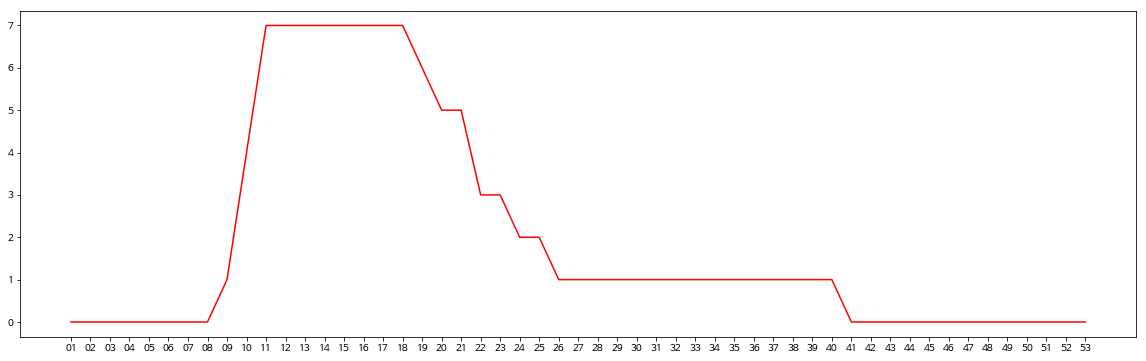

In [36]:
top_n = tmp2.sort_values('std', ascending=False).head(20)

for idx, row in list(top_n.iterrows())[:1]:
    plt.figure(figsize=(20,6))
    plt.plot(top_n.columns[:-1], row[:-1], "r-")
#     plt.plot(X, y, "b.")
#     plt.axis([0, 2, 0, 15])
plt.show()

## 계절음악: 월별 반복차트진입 횟수

In [37]:
def get_seasonal_songs(df, cols):
    tmp = df.loc[::, cols]
    tmp2 = tmp.applymap(lambda x: pd.notna(x) and (x != 1)).any(axis=1).to_frame()
    print(len(tmp2.loc[tmp2[0]==True]))
    return tmp2.loc[tmp2[0]==True]

In [38]:
# 봄 11~25
# 겨울 50~3
# 여름 27~40

cols_spring = [str(x) for x in range(11, 20)]
cols_summer = [str(x) for x in range(27, 41)]
cols_winter = [str(x) for x in [1,2,3,50,51,52,53]]

spring = get_seasonal_songs(tmp, cols_spring)
spring_set = set(spring.index.to_list())
summer = get_seasonal_songs(tmp, cols_summer)
summer_set = set(summer.index.to_list())
winter = get_seasonal_songs(tmp, cols_winter)
winter_set = set(winter.index.to_list())

only_spring = spring_set - summer_set - winter_set
only_summer = summer_set - spring_set - winter_set
only_winter = winter_set - spring_set - summer_set

print('spring')
lprint(spring_set - summer_set - winter_set)
# print('summer')
# lprint(summer_set - spring_set - winter_set)
# print('winter')
# lprint(winter_set - spring_set - summer_set)

72
54
35
spring
38


/home/jake/.virtualenvs/workspace/lib/python3.6/site-packages/pandas/core/indexing.py:969: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


{('10cm', '봄이 좋냐??'),
 ('DEAN', 'instagram'),
 ('Fitz & The Tantrums', 'HandClap'),
 ('Idina Menzel', 'Let It Go'),
 ('Imagine Dragons', 'Thunder'),
 ('Jason Mraz', 'Living In The Moment'),
 ('Shawn Mendes', 'There`s Nothing Holdin` Me Back'),
 ('The Chainsmokers, Coldplay', 'Something Just Like This'),
 ('iKON', '사랑을 했다 (LOVE SCENARIO)'),
 ('길구봉구', '바람이 불었으면 좋겠어'),
 ('닐로 (Nilo)', '지나오다'),
 ('로꼬 (LOCO), 유주 (여자친구)', '우연히 봄'),
 ('로이킴', '그때 헤어지면 돼'),
 ('마마무 (Mamamoo)', '별이 빛나는 밤'),
 ('멜로망스(MeloMance)', 'You'),
 ('모모랜드 (MOMOLAND)', '뿜뿜'),
 ('버스커 버스커 (Busker Busker)', '꽃송이가'),
 ('버스커 버스커 (Busker Busker)', '벚꽃 엔딩'),
 ('버스커 버스커 (Busker Busker)', '여수 밤바다'),
 ('버스커 버스커 (Busker Busker)', '외로움 증폭장치 (브래드 드럼 한판 쉬기)'),
 ('버스커 버스커 (Busker Busker)', '첫사랑'),
 ('블락비 (Block B)', '몇 년 후에'),
 ('소유, 정기고', '썸 (Feat. 릴보이 Of 긱스)'),
 ('아이유 (IU)', '팔레트 (Feat. G-DRAGON)'),
 ('에디킴', '2 Years Apart'),
 ('여자친구 (GFRIEND)', '유리구슬 (Glass Bead)'),
 ('이수', 'My Way'),
 ('이하이', '한숨'),
 ('자이언티(Zion.T)', '뻔한 멜로디 (Feat. Crush

In [39]:
# spring.merge(tmp, left_index=True, right_index=True, how='left').T
tmp.loc[tmp.index.isin(only_spring)]

,week,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
singer,subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10cm,봄이 좋냐??,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,3.0,3.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEAN,instagram,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
Fitz & The Tantrums,HandClap,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
Idina Menzel,Let It Go,NaN,NaN,NaN,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Imagine Dragons,Thunder,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Jason Mraz,Living In The Moment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Shawn Mendes,There`s Nothing Holdin` Me Back,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,NaN
"The Chainsmokers, Coldplay",Something Just Like This,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
iKON,사랑을 했다 (LOVE SCENARIO),1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN


In [40]:
# spring.merge(tmp, left_index=True, right_index=True, how='left').T
tmp.loc[tmp.index.isin(only_winter)]

,week,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
singer,subject,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ariana Grande,Santa Tell Me,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,3.0,3.0,3.0,1.0
EXO,Universe,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,1.0,2.0,NaN
Mariah Carey,All I Want For Christmas Is You,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,6.0,3.0
"SG워너비, 브라운 아이드 걸스",Must Have Love (우리들의 겨울),2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
Sia,Snowman,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,2.0,NaN
Wanna One (워너원),Beautiful,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN
김조한,사랑에 빠지고 싶다,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,2.0,1.0
볼빨간사춘기,심술,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0
빅뱅,뱅뱅뱅 (BANG BANG BANG),1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0


# 제작사, 유통사의 다양성이 감소하고 있다?

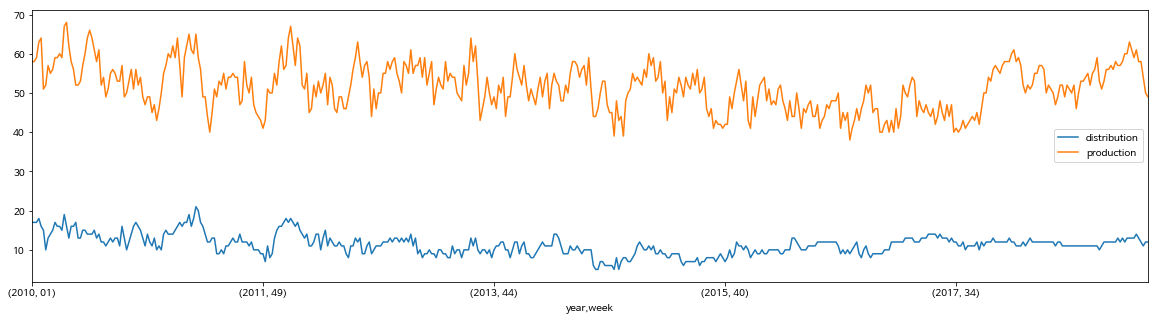

In [41]:
def draw_prod_dist(maximum=100, figsize=(20,8)):
    ranking_100 = ranking.loc[ranking['ranking_num'] <= maximum]
    ranking_100.head()

    tmp = ranking_100.groupby(['year', 'week']).agg({'distribution': 'nunique', 'production': 'nunique'})
    tmp.head()
    tmp.plot(figsize=figsize)

draw_prod_dist(100, (20, 5))

# 대형제작사가 독식한다?

In [42]:
def get_prod_value_counts(maximum=100):
    ranking_100 = ranking.loc[ranking['ranking_num'] <= maximum]
    ranking_100.head()

    return ranking_100['production'].value_counts()

# get_prod_value_counts(100).head(10).index
big = get_prod_value_counts(100).head(10).index.tolist()
big

['Stone Music Entertainment',
 'YG Entertainment',
 'SM Entertainment',
 'JYP Entertainment',
 '큐브엔터테인먼트',
 '아메바컬쳐',
 '빅히트 엔터테인먼트',
 '카카오 M',
 '스타쉽엔터테인먼트',
 '아이엠비씨']

In [43]:
ranking.head()
ranking.loc[ranking['production'].isin(big)].head()
# ranking.loc[ranking['production'].isin(big), ['production']].plot(figsize=(20, 8))

,album,album_img_src,change,date,distribution,gaon_score,production,ranking,singer,subject,week,year,ranking_num,ranking_value,gaon_score_num,gaon_score_total,gaon_score_rate
4,Atelier,,new,2009.12.20~2009.12.26,카카오 M,None,카카오 M,5,지아 (Zia),술 한잔 해요,01,2010,5,195,NaN,0.0,NaN
13,1집 1_59PM,,new,2009.12.20~2009.12.26,카카오 M,None,JYP Entertainment,14,2PM,Heartbeat,01,2010,14,186,NaN,0.0,NaN
14,Atelier,,new,2009.12.20~2009.12.26,카카오 M,None,카카오 M,15,지아 (Zia),그녀처럼,01,2010,15,185,NaN,0.0,NaN
24,Sad Freedom,,new,2009.12.20~2009.12.26,카카오 M,None,JYP Entertainment,25,박진영,No Love No More,01,2010,25,175,NaN,0.0,NaN
27,Beast Is The B2ST,,new,2009.12.20~2009.12.26,Stone Music Entertainment,None,큐브엔터테인먼트,28,비스트 (Beast),Mystery,01,2010,28,172,NaN,0.0,NaN


In [44]:
# distribution
def get_dist_value_counts(maximum=100):
    ranking_100 = ranking.loc[ranking['ranking_num'] <= maximum]
    ranking_100.head()

    return ranking_100['distribution'].value_counts()

get_dist_value_counts(100).head()

카카오 M                        16956
Stone Music Entertainment    11232
지니뮤직                         8129 
Universal Music              2734 
NHN벅스                        2241 
Name: distribution, dtype: int64

# 가수 다양성 해마다 줄어든다?

In [45]:
dcree = ranking_100.groupby('year').agg({'singer':'nunique', 'production':'nunique', 'distribution':'nunique'}); dcree
dcree.reset_index(inplace=True); dcree
# dcree.to_csv(dir_tableau + 'decreasing_diversity.tsv', sep='\t', index=False)

,year,singer,production,distribution
0,2010,519,293,41
1,2011,563,303,40
2,2012,569,293,29
3,2013,596,305,29
4,2014,585,286,25
5,2015,525,242,27
6,2016,456,208,19
7,2017,339,155,18
8,2018,246,134,18
9,2019,122,90,14


# 로이킴?

In [46]:
ranking.loc[ranking['singer'].str.contains('로이킴')]

,album,album_img_src,change,date,distribution,gaon_score,production,ranking,singer,subject,week,year,ranking_num,ranking_value,gaon_score_num,gaon_score_total,gaon_score_rate
14700,슈퍼스타K4 TOP12 Part 1,,new,2012.10.14~2012.10.20,Stone Music Entertainment,None,Stone Music Entertainment,1,"로이킴, 정준영",먼지가 되어,43,2012,1,199,NaN,0.000000e+00,NaN
14801,슈퍼스타K4 TOP12 Part 1,,down1,2012.10.21~2012.10.27,Stone Music Entertainment,None,Stone Music Entertainment,2,"로이킴, 정준영",먼지가 되어,44,2012,2,198,NaN,0.000000e+00,NaN
14809,슈퍼스타K4 TOP12 Part 2,,new,2012.10.21~2012.10.27,Stone Music Entertainment,None,Stone Music Entertainment,10,로이킴,휘파람,44,2012,10,190,NaN,0.000000e+00,NaN
14906,슈퍼스타K4 TOP12 Part 1,,down5,2012.10.28~2012.11.03,Stone Music Entertainment,None,Stone Music Entertainment,7,"로이킴, 정준영",먼지가 되어,45,2012,7,193,NaN,0.000000e+00,NaN
14911,슈퍼스타K4 TOP12 Part 2,,down2,2012.10.28~2012.11.03,Stone Music Entertainment,None,Stone Music Entertainment,12,로이킴,휘파람,45,2012,12,188,NaN,0.000000e+00,NaN
14921,슈퍼스타K4 TOP12 Part 3,,new,2012.10.28~2012.11.03,Stone Music Entertainment,None,Stone Music Entertainment,22,로이킴,청개구리,45,2012,22,178,NaN,0.000000e+00,NaN
15009,슈퍼스타K4 TOP12 Part 1,,down3,2012.11.04~2012.11.10,Stone Music Entertainment,None,Stone Music Entertainment,10,"로이킴, 정준영",먼지가 되어,46,2012,10,190,NaN,0.000000e+00,NaN
15012,슈퍼스타K4 TOP12 Part 2,,down1,2012.11.04~2012.11.10,Stone Music Entertainment,None,Stone Music Entertainment,13,로이킴,휘파람,46,2012,13,187,NaN,0.000000e+00,NaN
15016,슈퍼스타K4 TOP12 Part 4,,new,2012.11.04~2012.11.10,Stone Music Entertainment,None,Stone Music Entertainment,17,로이킴,서울의 달,46,2012,17,183,NaN,0.000000e+00,NaN
15043,슈퍼스타K4 TOP12 Part 3,,down22,2012.11.04~2012.11.10,Stone Music Entertainment,None,Stone Music Entertainment,44,로이킴,청개구리,46,2012,44,156,NaN,0.000000e+00,NaN


# 총 몇주?

In [47]:
ranking_100.groupby(['year', 'week']).agg({'week': 'count'}).shape

(484, 1)

# 전체 몇곡?

In [48]:
# ranking_100.groupby(['singer', 'subject']).agg({'week': 'count'}).head()
ranking_100.groupby(['singer', 'subject']).agg({'week': 'count'}).shape

(9754, 1)

# 버스커 2집?

In [49]:
ranking_100.loc[ranking_100['singer']=='버스커 버스커 (Busker Busker)'].head()
# ranking_100.loc[ranking_100['album']=='버스커버스커 2집'].head()

,album,album_img_src,change,date,distribution,gaon_score,production,ranking,singer,subject,week,year,ranking_num,ranking_value,gaon_score_num,gaon_score_total,gaon_score_rate
9300,슈퍼스타K3 TOP 11 Part 1,,new,2011.10.02~2011.10.08,Stone Music Entertainment,None,Stone Music Entertainment,1,버스커 버스커 (Busker Busker),동경소녀,42,2011,1,199,NaN,0.0,3.859794
9403,슈퍼스타K3 TOP 11 Part 1,,down3,2011.10.09~2011.10.15,Stone Music Entertainment,None,Stone Music Entertainment,4,버스커 버스커 (Busker Busker),동경소녀,43,2011,4,196,NaN,0.0,2.865256
9416,슈퍼스타K3 TOP 11 Part 2,,new,2011.10.09~2011.10.15,Stone Music Entertainment,None,Stone Music Entertainment,17,버스커 버스커 (Busker Busker),Livin`La Vida Loca (Ricky Martin),43,2011,17,183,NaN,0.0,1.388849
9505,슈퍼스타K3 TOP 11 Part 3,,new,2011.10.16~2011.10.22,Stone Music Entertainment,None,Stone Music Entertainment,6,버스커 버스커 (Busker Busker),정류장,44,2011,6,194,NaN,0.0,2.408344
9510,슈퍼스타K3 TOP 11 Part 1,,down7,2011.10.16~2011.10.22,Stone Music Entertainment,None,Stone Music Entertainment,11,버스커 버스커 (Busker Busker),동경소녀,44,2011,11,189,NaN,0.0,1.732612


# 가온스코어 추이?

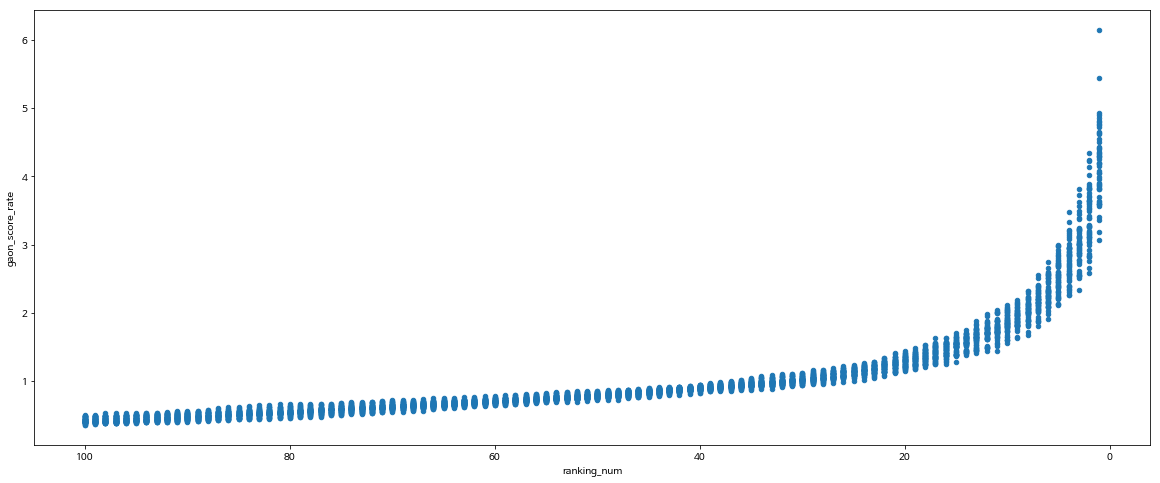

In [50]:
tmp = ranking_100.loc[(ranking['year'] == '2018'), ['ranking_num', 'gaon_score_rate']]; tmp.head()
# tmp = ranking_100.loc[(ranking['year'].isin(['2018', '2019'])), ['ranking_num', 'gaon_score_rate']]; tmp.head()
# tmp['gaon_score_rate'] = tmp['gaon_score_rate'].apply(np.log); tmp.head()
tmp.plot('ranking_num', 'gaon_score_rate', kind='scatter', figsize=(20, 8))
plt.gca().invert_xaxis()

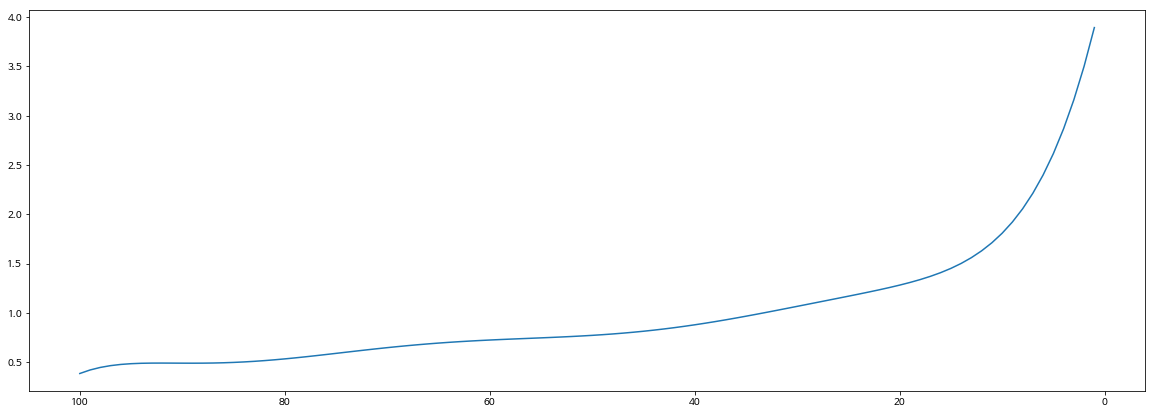

In [51]:
predict= np.array(range(1, 101)).reshape(-1, 1)

X = tmp['ranking_num'].values.reshape(-1, 1)
y = tmp['gaon_score_rate'].values.reshape(-1, 1)


def draw_prediction(degree):
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)

    rgr = linear_model.LinearRegression()
    rgr.fit(X_, y)
    
    predict_ = poly.fit_transform(predict)
    
    y_plot = rgr.predict(predict_)
    x_plot = predict
    plt.figure(figsize=(20,7))
    plt.plot(x_plot, y_plot, )
    plt.gca().invert_xaxis()


draw_prediction(7)

In [52]:
predict= np.array(range(1, 101)).reshape(-1, 1)

X = tmp['ranking_num'].values.reshape(-1, 1)
y = tmp['gaon_score_rate'].values.reshape(-1, 1)

def get_prediction():
    poly = PolynomialFeatures(degree=7)
    X_ = poly.fit_transform(X)
    rgr = linear_model.LinearRegression()
    rgr.fit(X_, y)
    
    predict_ = poly.fit_transform(predict)
    return rgr.predict(predict_)


tmp = get_prediction().reshape(1, -1)[0].tolist()
score_list = [np.nan] + tmp
score_list[:10]

[nan,
 3.8949240536356844,
 3.5021948633635422,
 3.161965226565557,
 2.868205235044348,
 2.6154194150227696,
 2.398612838511903,
 2.2132586038569935,
 2.055266658880087,
 1.9209539400380868]

# 가수 랭킹

In [58]:
top_singer = ranking_100.groupby('singer').agg({'gaon_score_rate':'sum'}).sort_values('gaon_score_rate', ascending=False).head(20)
top_singer.reset_index(inplace=True)

top_singer

,singer,gaon_score_rate
0,아이유 (IU),1168.348811
1,방탄소년단,655.767579
2,빅뱅,636.285717
3,다비치,562.728595
4,볼빨간사춘기,556.336642
5,EXO,540.449599
6,TWICE,519.245471
7,버스커 버스커 (Busker Busker),514.746546
8,악동뮤지션 (AKMU),411.941491
9,2NE1 (투애니 원),411.185922


In [59]:
tmp = ranking_100.groupby(['singer', 'subject']).agg({'week':'count'})
tmp.reset_index(inplace=True)
tmp.head()

sncn = tmp.groupby('singer').agg({'subject':'count'})
sncn.reset_index(inplace=True)
sncn.sort_values('subject', ascending=False).head(20)

,singer,subject
109,EXO,112
1136,샤이니 (SHINee),83
977,방탄소년단,80
1413,아이유 (IU),80
1081,비스트 (Beast),75
346,f(x),62
1197,소녀시대,61
1785,인피니트 (Infinite),61
2228,포맨 (4Men),59
1091,비투비 (BTOB),58


In [63]:
scsb = top_singer.merge(sncn, on='singer', how='inner')
scsb['mean_score'] = scsb['gaon_score_rate'] / scsb['subject']
scsb.sort_values('mean_score', ascending=False)

# scsb.sort_values('mean_score', ascending=False).to_csv(dir_tableau + 'mean_score.tsv', sep='\t', index=False)

,singer,gaon_score_rate,subject,mean_score
18,BLACKPINK,318.733385,10,31.873339
4,볼빨간사춘기,556.336642,21,26.492221
2,빅뱅,636.285717,38,16.744361
6,TWICE,519.245471,32,16.226421
7,버스커 버스커 (Busker Busker),514.746546,33,15.598380
15,헤이즈 (Heize),358.431655,24,14.934652
0,아이유 (IU),1168.348811,80,14.604360
9,2NE1 (투애니 원),411.185922,30,13.706197
8,악동뮤지션 (AKMU),411.941491,38,10.840566
14,마마무 (Mamamoo),362.375563,36,10.065988


# ---

In [56]:
ranking_100.head()

,album,album_img_src,change,date,distribution,gaon_score,production,ranking,singer,subject,week,year,ranking_num,ranking_value,gaon_score_num,gaon_score_total,gaon_score_rate
0,우리 사랑하게 됐어요,,new,2009.12.20~2009.12.26,카카오 M,None,내가 네트워크,1,"가인 (브라운 아이드 걸스), 조권 (2AM)",우리 사랑하게 됐어요.,01,2010,1,199,NaN,0.0,3.859794
1,Shadow (Repackage),,new,2009.12.20~2009.12.26,카카오 M,None,후크엔터테인먼트,2,이승기,처음처럼 그때처럼 (Feat. 강민경),01,2010,2,198,NaN,0.0,3.479866
2,크리스마스에 눈이 올까요? OST,,new,2009.12.20~2009.12.26,카카오 M,None,아이에이치큐,3,거미,그대라서,01,2010,3,197,NaN,0.0,3.150278
3,Absolute First Album,,new,2009.12.20~2009.12.26,Stone Music Entertainment,None,코어컨텐츠미디어,4,티아라 (T-ara),Bo Peep Bo Peep,01,2010,4,196,NaN,0.0,2.865256
4,Atelier,,new,2009.12.20~2009.12.26,카카오 M,None,카카오 M,5,지아 (Zia),술 한잔 해요,01,2010,5,195,NaN,0.0,2.619539
